In [31]:
import os
import sys
import time
import json
import psycopg2
import psycopg2.extensions
import pandas as pd
import numpy as np
from itertools import product
import pymongo
import matplotlib.pyplot as plt

In [46]:
class Experiment:

    """
    Class designed to perform response time experiment on postgres and mongoDB
    """

    def __init__(self):
        self.person = None
        self.postgres_settings = None
        self.mongodb_settings = None
        self.mongoclient = None
        self.mongodb = None
        self.postgres_con = None
        self.postgres_cur = None
        
        # Set class variables

        # Data frame for eperiment logging 
        self.results = pd.DataFrame(columns = ["person", "data_set", "data_store", "data_size", "query", "trial", "response_time"])

        # Dictionary with data_set names
        self.data_set = {0: "arrest_db",
                         1: "movies_db"}

        # Dictionary with data_size options per data_set
        self.data_size = {0: {0: "50000", 1: "8000"},
                          1: {0: "60000", 1: "10000"},
                          2: {0: "80000", 1: "13000"},
                          3: {0: "110000", 1: "18000"},
                          4: {0: "140000", 1: "23000"}}

        # Dictionary with data_store names
        self.data_store = {0: 'relational',
                           1: 'document'}

        # Dictionary with query ids
        self.query = {i:str(i) for i in range(12)}
        self.query[0]='import'

        # Dictionary with trail ids
        self.trail = {i:str(i+1) for i in range(10)}
        
        # Dictionary of query strings
        self.query_strings = {0: {0: [], 1: []},
                              1: {0: [], 1: []}}

        # List of dimension space of the experiment
        self.dimensions = [self.data_set.keys(), self.data_store.keys(), self.data_size.keys(), self.query.keys(), self.trail.keys()]

        # List of all combinations in the dimension space of the experiment
        self.cases = list(product(*self.dimensions))

        # Initialize cache
        self.cache = []
        
        print('Created instance of Experiment class to measure database response times')
        
    def connect(self, postgres_settings, mongodb_settings):
        self.postgres_settings = postgres_settings
        self.mongodb_settings = mongodb_settings
        
        try:
            # Connect to mongoDB
            self.mongoclient = pymongo.MongoClient(self.mongodb_settings['host'])
            # Connect to database in mongoDB
            self.mongodb = self.mongoclient[self.mongodb_settings['database']]
        except:
            print('Connection to MongoDB failed')
        else:
            print('Connection to MongoDB successful')
            
        try:    
            # Connect to postgres
            self.postgres_con = psycopg2.connect(**self.postgres_settings)
            # Create a cursor in postgres
            self.postgres_cur = self.postgres_con.cursor()    
        except:
            print('Connection to Postgres failed')
        else:
            print('Connection to Postgres successful')
            
    def txt_to_queries(self, path_queries, file_name):
        
        file_location = os.path.join(path_queries, file_name)
        
        with open(file_location) as handle:
            raw = handle.readlines()

        # Initialize temporary variable for query string and list
        query_str = ""
        query_lst = []
        
        # Extract queries
        for nrow in range(len(raw)):

            # Check for end identifier, else add to query string   
            if raw[nrow][0:2] == '.E':
                query_lst.append(query_str[:-1])
                query_str = ""
            else:
                query_str += raw[nrow] 
            
        return query_lst
    
    def prepare_databases(self, path_queries):
        
        ## Prepare mongoDB
        
        #Drop collections
        for collection in self.mongodb.list_collection_names():
            try:
                self.mongodb[collection].drop()
            except:
                print('Drop of MongoDB collection {} failed'.format(collection))
        
        ## Prepare postgres
        
        # Read file with create table queries
        query_lst = self.txt_to_queries(path_queries, "create_tables.txt")
                
        # Drop tables
        for query in query_lst:
            try:
                self.postgres_cur.execute('DROP TABLE IF EXISTS ' + query.split()[2][:-1])
            except:
                print('Drop of Postgres table {} failed'.format(query.split()[2][:-1]))
        self.postgres_con.commit()
        
        # Create tables
        for query in query_lst:
            try:
                self.postgres_cur.execute(query)
            except:
                print('Creation of Postgres table {} failed'.format(query.split()[2][:-1]))
        self.postgres_con.commit()
        
        ## Load queries
        self.query_strings[0][0] = self.txt_to_queries(path_queries, "sql_queries_arrest.txt")
    
    def log_response_time(self, case, response_time):
        
        new_row = {"person": self.person,
                   "data_set": self.data_set[case[0]], 
                   "data_store": self.data_store[case[1]], 
                   "data_size": self.data_size[case[2]][case[1]],
                   "query": self.query[case[3]], 
                   "trial": self.trail[case[4]], 
                   "response_time": response_time}
        
        self.results = self.results.append(new_row, ignore_index=True)
    
    def update_postgres(self, case, path):
        
        # Drop data in datastore
        for filename in os.listdir(path):
            with open(os.path.join(path,filename), 'r') as file:
                try:
                    self.postgres_cur.execute('TRUNCATE TABLE ' + filename.split('.')[0])
                except:
                    print('\t Drop of {} table failed'.format(filename.split('.')[0]))
            self.postgres_con.commit()
        print('\t All postgres tables dropped') 

        # Import data to datastore
        start = time.time()
        for filename in os.listdir(path):
            with open(os.path.join(path,filename), 'r') as file:
                try:
                    self.postgres_cur.copy_expert(sql="""
                    COPY {} FROM STDIN WITH
                        CSV
                        HEADER
                        DELIMITER AS ','
                    """.format(filename.split('.')[0]), file=file)
                except:
                    print('\t Import of {} table failed'.format(filename.split('.')[0]))
            self.postgres_con.commit()
        end = time.time()  
        
        response_time = (end-start)*1000
        
        self.log_response_time(case, response_time)
        
        print('\t \t Imported data size {} to postgres in {} ms'.format(self.data_size[case[2]][case[1]], response_time))

    def update_mongodb(self, case, path):
        
        # Drop data in datastore
        for collection in self.mongodb.list_collection_names():
            try:
                self.mongodb[collection].drop()
            except:
                print('\t Drop of {} collection failed'.format(collection))
        print('\t All mongoDB tables dropped') 

        # Import data to datastore
        start = time.time()
        for filename in os.listdir(path):
            with open(os.path.join(path,filename), 'r') as file:
                try:
                    file_data = json.load(file)
                    col = self.mongodb[filename.split('.')[0]]
                    if isinstance(file_data, list):
                        col.insert_many(file_data)
                    elif isinstance(file_data, dict):
                        if len(file_data.keys())<20:
                            col.insert_one(file_data)
                        else:
                            for key in file_data.keys():
                                col.insert_one(file_data[key])
                    else:
                        print('Unknown file type')
                except:
                    print('\t Import of {} collection failed'.format(filename.split('.')[0]))
        end = time.time()
        
        response_time = (end-start)*1000
        
        self.log_response_time(case, response_time)
        
        print('\t \t Imported data size {} to mongoDB in {} ms'.format(self.data_size[case[2]][case[1]], response_time))

    def update_databases(self, case):
        
        if (case[2] == 0): # data_size 0
            print('--------------------------------------------------------------------------------------')
            print('Start with experiment on {} data set in {} database'.format(self.data_set[case[0]],self.data_store[case[1]])) 

        # Find and open path with new data
        path = os.path.join(self.data_set[case[0]] + '_' + self.data_store[case[1]], self.data_size[case[2]][case[0]])

        if case[1] == 0: # data_store 0 postgres
            
            self.update_postgres(case, path)
            
        else: # data_store 1 mongodb
            
            self.update_mongodb(case, path)
            
    def run_postgres_query(self, case):
        
        start = time.time()
        try:
            self.postgres_cur.execute(self.query_strings[case[0]][case[1]][case[3]-1])
            self.postgres_cur.fetchall()
        except:
            print('\t Query failed')
        end = time.time()

        response_time = (end-start)*1000
        
        # Log response time
        self.log_response_time(case, response_time)
        
        # Cache the response time
        self.cache.append(response_time)
    
    def run_mongodb_query_movies(self, case):
        
        if case[3] == 1:
            start = time.time()
            try:
                mycol = self.mongodb["movies_info"]
                mydoc = mycol.find( { }, { 'year':1, 'genres':1 , 'type':1, 'rated':1, 'awards':1 } )
                temp = [i for i in mydoc] # Equivalent to fetchall for postgres
            except:
                print('\t Query failed')
            end = time.time()
            
        elif case[3] == 2:
            start = time.time()
            try:
                mycol = self.mongodb["movies_info"]
                mydoc = mycol.find(
                    {
                        'genres': {
                            '$in': [
                                "Western",
                                "Drama",
                                "Comedy"
                                ]
                            }
                        }
                    )
                temp = [i for i in mydoc] # Equivalent to fetchall for postgres
            except:
                print('\t Query failed')
            end = time.time()
            
        elif case[3] == 3:
            start = time.time()
            try:
                mycol = self.mongodb["movies_info"]
                mydoc = mycol.find(
                    {  
                        # The filter part
                        'genres': {
                            '$in': [
                                "Western",
                                "Drama",
                                "Comedy"
                                ]
                            }
                        },
                    # The SELECT PART
                    { 'year':1, 'genres':1 , 'type':1, 'rated':1, 'awards':1 }
                )
                temp = [i for i in mydoc] # Equivalent to fetchall for postgres
            except:
                print('\t Query failed')
            end = time.time()
            
        elif case[3] == 4:
            start = time.time()
            try:
                mycol = self.mongodb["all_comments"]
                mydoc = mycol.aggregate([
                {
                    '$lookup':{
                        'from': "movies",
                        'localField': "movie_id",
                        'foreignField': "_id",
                        'as': "movie"
                        }
                    },  
                {
                    '$unwind': {
                        'path': "$movie",
                        'preserveNullAndEmptyArrays': False
                        }
                    },
                {
                    '$match': {
                        'movie.genres': {
                            '$in': [
                                "Western",
                                "Drama",
                                "Comedy"
                                ]
                            }
                        }
                    }
                ])
                temp = [i for i in mydoc] # Equivalent to fetchall for postgres
            except:
                print('\t Query failed')
            end = time.time()
            
        elif case[3] == 5:
            start = time.time()
            try:
                mycol = self.mongodb["all_comments"]
                mydoc = mycol.aggregate([
                    {
                        '$lookup':{
                            'from': "movies",
                            'localField': "movie_id",
                            'foreignField': "_id",
                            'as': "movie"
                            }
                        },  
                    {
                        '$unwind': {
                            'path': "$movie",
                            'preserveNullAndEmptyArrays': False
                            }
                        }, 
                    {
                        # These can be alter to change the number of returned values
                         '$project':{
                            'name' : 1,
                            'email' : 1,
                            'title' : '$movie.title',
                            'genres' : "$movie.genres",
                            'rated' : "$movie.rated",
                            } 
                        }
                    ]
                )
                temp = [i for i in mydoc] # Equivalent to fetchall for postgres
            except:
                print('\t Query failed')
            end = time.time()
            
        elif case[3] == 6:
            start = time.time()
            try:
                mycol = self.mongodb["all_comments"]
                mydoc = mycol.aggregate([
                    {
                        '$lookup':{
                            'from': "movies",
                            'localField': "movie_id",
                            'foreignField': "_id",
                            'as': "movie"
                            }
                        },  
                    {
                        '$unwind': {
                            'path': "$movie",
                            'preserveNullAndEmptyArrays': False
                            }
                        },
                    {
                        '$match': {
                            'movie.genres': {
                                '$in': [
                                    "Western",
                                    "Drama",
                                    "Comedy"
                                    ]
                                }
                            }
                        },
                    {
                        # These can be alter to change the number of returned values
                         '$project':{
                            'name' : 1,
                            'email' : 1,
                            'title' : '$movie.title',
                            'genres' : "$movie.genres",
                            'rated' : "$movie.rated"
                            } 
                        }
                    ])
                temp = [i for i in mydoc] # Equivalent to fetchall for postgres
            except:
                print('\t Query failed')
            end = time.time()
            
        elif case[3] == 7:
            start = time.time()
            try:
                mycol = self.mongodb["all_comments"]
                mydoc = mycol.aggregate([
                    {
                        '$lookup':{
                            'from': "movies",
                            'localField': "movie_id",
                            'foreignField': "_id",
                            'as': "movie"
                            }
                        },  
                    {
                        '$unwind': {
                            'path': "$movie",
                            'preserveNullAndEmptyArrays': False
                            }
                        },
                    {
                        '$lookup':{
                            'from': "users",
                            'localField': "name",
                            'foreignField': "name",
                            'as': "user"
                            }
                        },
                    {
                        '$unwind': {
                            'path': "$user",
                            'preserveNullAndEmptyArrays': False
                            }
                        },
                    {
                        '$match': {
                            'movie.genres': {
                                '$in': [
                                    "Western",
                                    "Drama",
                                    "Comedy"
                                    ]
                                }
                            }
                        }
                    ])
                temp = [i for i in mydoc] # Equivalent to fetchall for postgres
            except:
                print('\t Query failed')
            end = time.time()
            
        elif case[3] == 8:
            start = time.time()
            try:
                mycol = self.mongodb["all_comments"]
                mydoc = mycol.aggregate([
                    {
                        '$lookup':{
                            'from': "movies",
                            'localField': "movie_id",
                            'foreignField': "_id",
                            'as': "movie"
                            }
                        },  
                    {
                        '$unwind': {
                            'path': "$movie",
                            'preserveNullAndEmptyArrays': False
                            }
                        },
                    {
                        '$lookup':{
                            'from': "users",
                            'localField': "name",
                            'foreignField': "name",
                            'as': "user"
                            }
                        },
                    {
                        '$unwind': {
                            'path': "$user",
                            'preserveNullAndEmptyArrays': False
                            }
                        }, 
                    {
                        # These can be alter to change the number of returned values
                         '$project':{
                            'name' : 1,
                            'email' : 1,
                            'title' : '$movie.title',
                            'genres' : "$movie.genres",
                            'rated' : "$movie.rated",
                            'password': '$user.password'
                            } 
                        }
                    ])
                temp = [i for i in mydoc] # Equivalent to fetchall for postgres
            except:
                print('\t Query failed')
            end = time.time()
            
        elif case[3] == 9:
            start = time.time()
            try:
                mycol = self.mongodb["all_comments"]
                mydoc = mycol.aggregate([
                    {
                        '$lookup':{
                            'from': "movies",
                            'localField': "movie_id",
                            'foreignField': "_id",
                            'as': "movie"
                            }
                        },  
                    {
                        '$unwind': {
                            'path': "$movie",
                            'preserveNullAndEmptyArrays': False
                            }
                        },
                    {
                        '$lookup':{
                            'from': "users",
                            'localField': "name",
                            'foreignField': "name",
                            'as': "user"
                            }
                        },
                    {
                        '$unwind': {
                            'path': "$user",
                            'preserveNullAndEmptyArrays': False
                            }
                        },
                    {
                        '$match': {
                            'movie.genres': {
                                '$in': [
                                    "Western",
                                    "Drama",
                                    "Comedy"
                                    ]
                                }
                            }
                        }, 
                    {
                        # These can be alter to change the number of returned values
                         '$project':{
                            'name' : 1,
                            'email' : 1,
                            'title' : '$movie.title',
                            'genres' : "$movie.genres",
                            'rated' : "$movie.rated",
                            'password': '$user.password'
                            } 
                        }
                    ])
                temp = [i for i in mydoc] # Equivalent to fetchall for postgres
            except:
                print('\t Query failed')
            end = time.time()
            
        elif case[3] == 10:
            start = time.time()
            try:
                mycol = self.mongodb["movies_info"]
                mydoc = mycol.aggregate([
                        {
                        '$match': {
                            'genres': {
                              '$in': [
                                    "Western",
                                    "Drama",
                                    "Comedy"
                                    ]
                                }
                            }   
                        },
                    {
                        "$group" : {
                            '_id':"$year", 'count':{'$sum':1}}}
                ])
                temp = [i for i in mydoc] # Equivalent to fetchall for postgres
            except:
                print('\t Query failed')
            end = time.time()
            
        elif case[3] == 11:
            start = time.time()
            try:
                mycol = self.mongodb["all_comments"]
                mydoc = mycol.aggregate([
                    {
                        '$lookup':{
                            'from': "movies",
                            'localField': "movie_id",
                            'foreignField': "_id",
                            'as': "movie"
                            }
                        },  
                    {
                        '$unwind': {
                            'path': "$movie",
                            'preserveNullAndEmptyArrays': False
                            }
                        },
                    {
                        '$match': {
                            'movie.genres': {
                                '$in': [
                                    "Western",
                                    "Drama",
                                    "Comedy"
                                    ]
                                }
                            }
                        },
                    {
                        '$match': {
                            '$or': [
                                {'name': 'Theon Greyjoy'},
                                {'name': 'Jorah Mormont'},
                                {'name': 'Daario Naharis'},
                                {'name': 'Meera Reed'},
                                {'name': 'Olly'}
                                ]
                            }
                        },
                    {
                        "$group" : {
                            '_id':"$movie.year", 'count':{'$sum':1}}
                    }
                    ])
                temp = [i for i in mydoc] # Equivalent to fetchall for postgres
            except:
                print('\t Query failed')
            end = time.time()
            
        else:
            print(case[3])
            print('\t No query defined')
            
        response_time = (end-start)*1000
        
        return response_time
    
    def run_mongodb_query(self, case):
        
        if case[0] == 0:
            response_time = 10 # function for arrest db to be included
        else:
            response_time = self.run_mongodb_query_movies(case)
        
        # Log response time
        self.log_response_time(case, response_time)

        # Cache the response time
        self.cache.append(response_time)
    
    def reset_cache(self, case):
        
        print('\t \t Executed query {} 10 times with avg. response time {} ms'.format(self.query[case[3]],np.mean(self.cache)))

        self.cache = []
    
    def run_query(self, case):
        
        if case[1] == 0: # data_store 0 postgres

            # Execute query in postgres
            self.run_postgres_query(case)
            
            if case[4] == 9: # Final trail of query completed
                self.reset_cache(case)

        else: # data_store 1 mongodb

            # Execute query in mongodb
            self.run_mongodb_query(case)

            if case[4] == 9: # Final trail of query completed
                self.reset_cache(case)

    def execute(self, person):
        self.person = person
        
        # Run all experiments
        for case in self.cases:
    
            if (case[3] == 0) & (case[4] == 0): # query 0 and trail 0
                # Update database
                self.update_databases(case)
            elif case[3] == 0: # query 0
                continue # Import query is run only once in the update_databases step above 
            else:
                # run query
                self.run_query(case)
            
    def get_results(self):
        return self.results
    
    def export_results(self):
        self.results.to_csv('exp_results_{}.csv'.format(self.person))

In [47]:
# USER INPUT: set personal configurations here

# Configurations for postgres server: change values only, do not change keys
postgres_settings = {
    "user": "temp",
    "password": "1234",
    "host": "localhost",
    "port": "5432",
    "database": "mydb"
}

# Configurations for MongoDB: change values only, do not change keys
mongodb_settings = {
    "host": "mongodb://localhost:27017/",
    "database": "bigdata"
}

# Your name for experiment logging
person = 'rob'

In [48]:
test = Experiment()

Created instance of Experiment class to measure database response times


In [49]:
test.connect(postgres_settings, mongodb_settings)

Connection to MongoDB successful
Connection to Postgres successful


In [50]:
test.prepare_databases(os.getcwd())

In [51]:
test.execute('rob')

--------------------------------------------------------------------------------------
Start with experiment on arrest_db data set in relational database
	 All postgres tables dropped
	 	 Imported data size 50000 to postgres in 681.7700862884521 ms
	 	 Executed query 1 10 times with avg. response time 17.600512504577637 ms
	 	 Executed query 2 10 times with avg. response time 14.783382415771484 ms
	 	 Executed query 3 10 times with avg. response time 7.3451995849609375 ms
	 	 Executed query 4 10 times with avg. response time 39.83654975891113 ms
	 	 Executed query 5 10 times with avg. response time 242.41347312927246 ms
	 	 Executed query 6 10 times with avg. response time 192.07420349121094 ms
	 	 Executed query 7 10 times with avg. response time 73.36921691894531 ms
	 	 Executed query 8 10 times with avg. response time 198.15576076507568 ms
	 	 Executed query 9 10 times with avg. response time 83.32047462463379 ms
	 	 Executed query 10 10 times with avg. response time 10.981178283691

	 	 Executed query 9 10 times with avg. response time 10.0 ms
	 	 Executed query 10 10 times with avg. response time 10.0 ms
	 	 Executed query 11 10 times with avg. response time 10.0 ms
--------------------------------------------------------------------------------------
Start with experiment on movies_db data set in relational database
	 All postgres tables dropped
	 	 Imported data size 50000 to postgres in 796.2360382080078 ms
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 	 Executed query 1 10 times with avg. response time 0.1882791519165039 ms
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 	 Executed query 2 10 times with avg. response time 0.06897449493408203 ms
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Que

	 Query failed
	 Query failed
	 Query failed
	 	 Executed query 9 10 times with avg. response time 0.06210803985595703 ms
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 	 Executed query 10 10 times with avg. response time 0.06058216094970703 ms
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 	 Executed query 11 10 times with avg. response time 0.08454322814941406 ms
	 All postgres tables dropped
	 	 Imported data size 140000 to postgres in 2158.7207317352295 ms
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 	 Executed query 1 10 times with avg. response time 0.07402896881103516 ms
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query failed
	 Query 

In [26]:
df=test.get_results()

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2220 entries, 0 to 2219
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   person         2220 non-null   object 
 1   data_set       2220 non-null   object 
 2   data_store     2220 non-null   object 
 3   data_size      2220 non-null   object 
 4   query          2220 non-null   object 
 5   trial          2220 non-null   object 
 6   response_time  2220 non-null   float64
dtypes: float64(1), object(6)
memory usage: 121.5+ KB


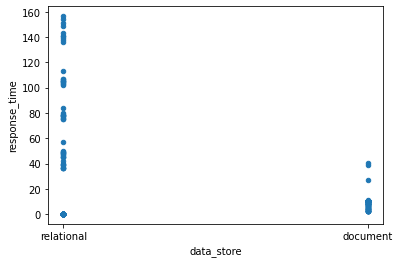

In [40]:
df[df['query']=='4'].plot(kind='scatter',x='data_store',y='response_time')
plt.show()

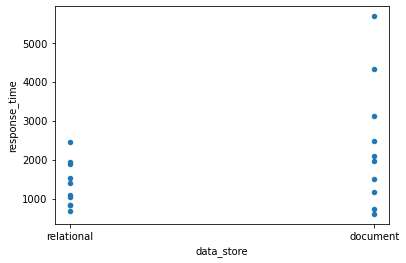

In [41]:
df[df['query']=='import'].plot(kind='scatter',x='data_store',y='response_time')
plt.show()

In [45]:
test.export_results()

AttributeError: 'Experiment' object has no attribute 'export_results'